<a href="https://colab.research.google.com/github/Prateek3214/webby/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your dataset on Google Drive
data_dir = '/content/drive/MyDrive/chest_xray'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import zipfile
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
from google.colab import drive  # For mounting Google Drive
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# Updated labels and image size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

# Function to load and preprocess data
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)  # Folder for each class
        class_num = labels.index(label)  # 0 for NORMAL, 1 for PNEUMONIA
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
                data.append([resized_arr, class_num])  # Append image and label
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(data)

In [ ]:
# Load train, test, and validation datasets
train_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/chest_xray/test'
val_dir = '/content/drive/MyDrive/chest_xray/chest_xray/val'



In [ ]:
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"
pneumonia_images = os.listdir(pneumonia_dir)

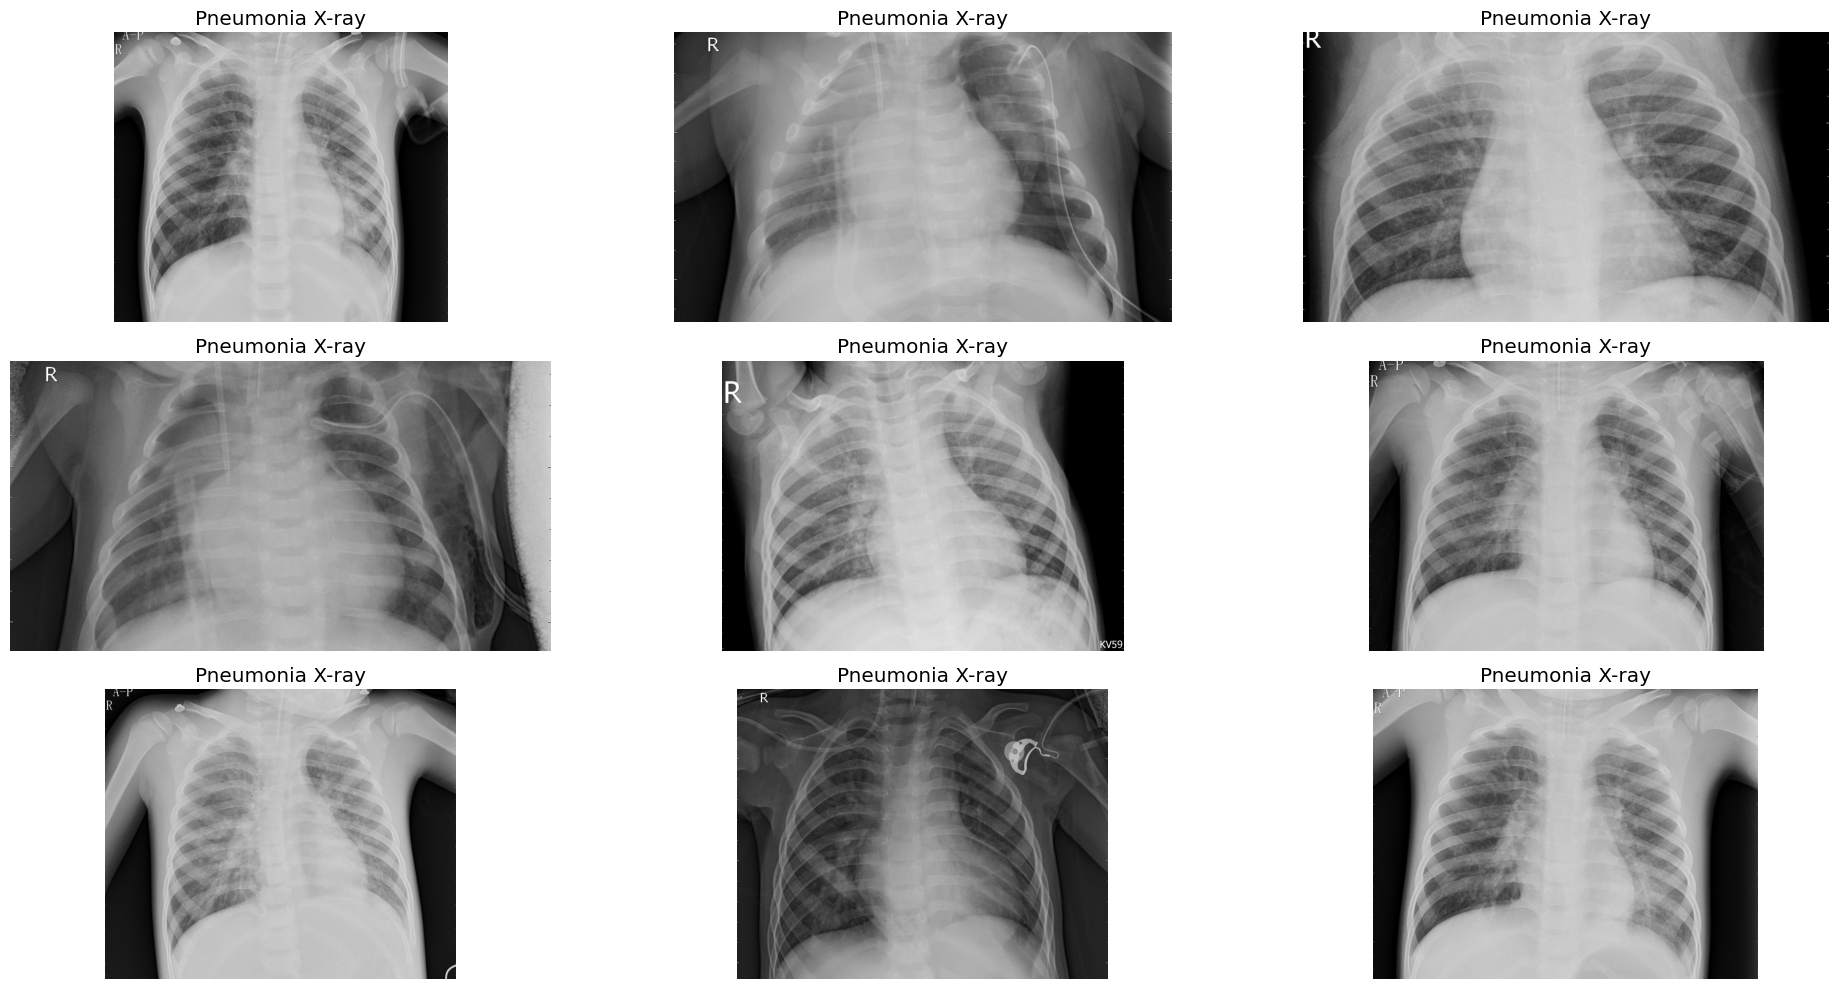

In [ ]:
# Plot the first 9 Pneumonia X-ray images
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(pneumonia_dir, pneumonia_images[i])  # Get the correct image path
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
)

valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/chest_xray/chest_xray/train",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/drive/MyDrive/chest_xray/chest_xray/val",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/chest_xray/chest_xray/test",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Class Weights Calculation
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes,
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
# Build VGG19 Model
base_model = VGG19(include_top=False, input_shape=(128, 128, 3), weights="imagenet")
for layer in base_model.layers[:-4]:  # Unfreeze last 4 layers
    layer.trainable = True

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Add Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(4608, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1152, activation="relu")(x)
output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.inputs, outputs=output)

In [ ]:

# Compile Model
sgd = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [ ]:
# Callbacks
checkpoint_path = "/content/drive/MyDrive/model.keras"
es = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose=1)
cp = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
)
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)


In [ ]:
# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[es, cp, lrr],
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1502s 28s/step - accuracy: 0.6758 - loss: 0.5780 - val_accuracy: 0.8125 - val_loss: 0.4453 - learning_rate: 1.0000e-04


In [ ]:

# Save the Model
if not os.path.exists("model_weights/"):
    os.mkdir("model_weights/")
model.save(filepath="model_weights/vgg19_model.h5", overwrite=True)

In [ ]:
# Evaluate Model
val_loss, val_accuracy = model.evaluate(valid_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8125 - loss: 0.4453
20/20 ━━━━━━━━━━━━━━━━━━━━ 255s 13s/step - accuracy: 0.8247 - loss: 0.3692
Validation Loss: 0.44528117775917053
Validation Accuracy: 0.8125
Test Loss: 0.3597452640533447
Test Accuracy: 0.8285256624221802


In [ ]:
# Analysis after Model Training
def plot_training_history(history):
    """Plots training and validation accuracy/loss curves."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

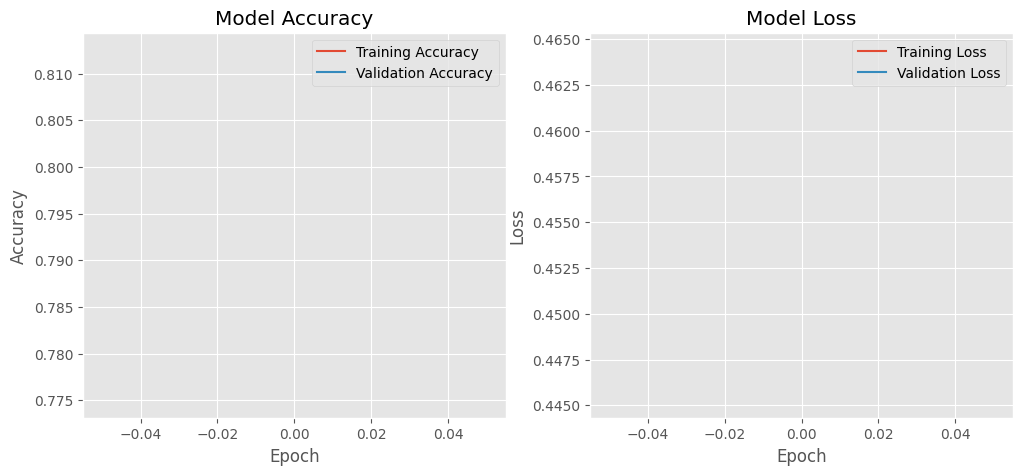

In [ ]:
# Plot training history
plot_training_history(history)


In [ ]:

# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step


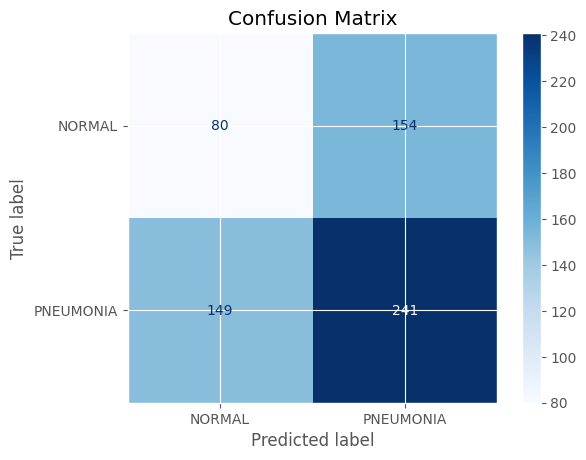

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
cr = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.35      0.34      0.35       234
   PNEUMONIA       0.61      0.62      0.61       390

    accuracy                           0.51       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.51      0.51       624



Please upload a chest X-ray image:


Saving person995_bacteria_2923.jpeg to person995_bacteria_2923.jpeg
Processing image: person995_bacteria_2923.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Raw Prediction Probabilities: [[0.62788296 0.372117  ]]


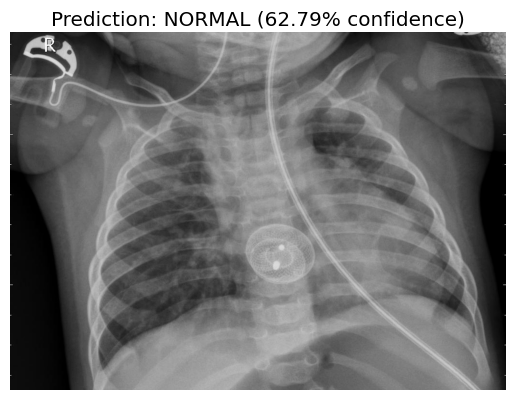

In [ ]:
# Prediction Functions
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
    img_resized = cv2.resize(img, (128, 128))  # Resize to match model input
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    img_normalized = img_rgb / 255.0  # Normalize pixel values to [0, 1]
    img_final = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    return img_final

def predict_pneumonia(image_path):
    processed_img = preprocess_image(image_path)
    prediction = model.predict(processed_img)
    print(f"Raw Prediction Probabilities: {prediction}")

    class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}  # Ensure this matches your training labels
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_class, confidence

# User Input Prediction
def user_input_prediction():
    from google.colab import files
    print("Please upload a chest X-ray image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing image: {filename}")
        predicted_class, confidence = predict_pneumonia(filename)

        # Display the uploaded image
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")
        plt.show()

# Call the function to enable user input and prediction
user_input_prediction()